In this notebook, we need to do the following:
- Define the number of check in stations and voting booths in each precinct. This should be easy, just finding a cutoff for small or big precincts.
- Identify precincts by populace of disenfranchised voters. Need to see if this will create several clusters, or just a binary split.

In [71]:
import pandas as pd
import geopandas as gpd
import numpy as np

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

In [19]:
data = pd.read_csv('2026_predictions.csv')
data.sample(6)

,total,race_percent_white,race_percent_black,race_percent_native,race_percent_asian,race_percent_pacific_islander,race_percent_hispanic,race_percent_other,income_percent_below_15K,income_percent_15K_35K,...,female_percent,disability_percent,male_disability_percent,female_disability_percent,district,year,is_midterm,lagged_turnout,lagged_percentage_turnout,ballots_cast
691,3083.534380,0.293793,0.523425,0.000000e+00,9.658246e-02,0.000000,0.030836,0.000000,0.328201,0.224791,...,0.480832,0.093597,0.019085,0.074511,PITTSBURGH WARD 3 DIST 1,2026,1,148,62.45,101
865,6716.353446,0.857552,0.069235,0.000000e+00,4.161746e-02,0.000000,0.000000,0.004022,0.123477,0.147959,...,0.544166,0.142590,0.055360,0.087230,ROSS WARD 4 DIST 2,2026,1,915,84.02,788
188,3341.202971,0.837164,0.027502,1.322144e-07,5.022195e-02,0.000005,0.013723,0.003580,0.208739,0.333101,...,0.466434,0.224354,0.116343,0.108011,ETNA WARD 2,2026,1,488,70.93,408
365,3343.414913,0.656797,0.113512,1.373188e-03,1.754916e-01,0.000000,0.000000,0.015287,0.170308,0.161435,...,0.486014,0.130240,0.060546,0.069694,MONROEVILLE WARD 2 DIST 3,2026,1,896,81.90,752
203,3012.071388,0.894334,0.002153,0.000000e+00,1.334625e-08,0.000000,0.024531,0.000000,0.189754,0.169337,...,0.506309,0.304045,0.192159,0.111885,FORWARD DIST 1,2026,1,315,84.22,255
755,2205.303907,0.851051,0.093222,6.374635e-06,4.460411e-02,0.000000,0.000000,0.034979,0.000000,0.096379,...,0.489107,0.150504,0.106469,0.044035,PITTSBURGH WARD 6 DIST 3,2026,1,536,70.16,491


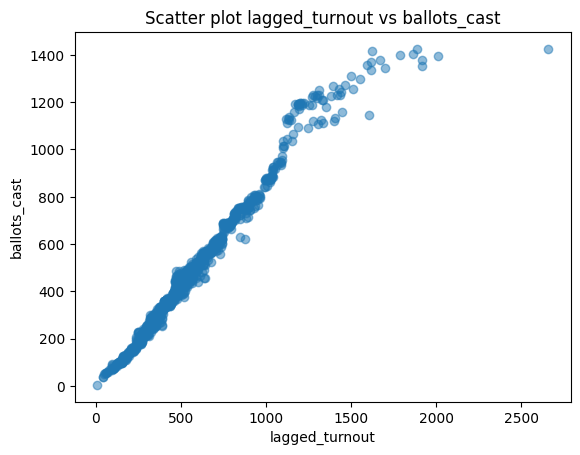

In [20]:
# Plot lagged_turnout vs ballots_cast

import matplotlib.pyplot as plt
plt.scatter(data.lagged_turnout, data.ballots_cast, alpha=0.5)
plt.title('Scatter plot lagged_turnout vs ballots_cast')
plt.xlabel('lagged_turnout')
plt.ylabel('ballots_cast')
plt.show()

Based on the trends, we can differentiate between precincts with 1200+ voters last year and those with less.

In [21]:
data['check_in_stations'] = 1
data['voting_booths'] = ((data['lagged_turnout'] > 1200).astype(int) + 1) * 3

In [22]:
data

,total,race_percent_white,race_percent_black,race_percent_native,race_percent_asian,race_percent_pacific_islander,race_percent_hispanic,race_percent_other,income_percent_below_15K,income_percent_15K_35K,...,male_disability_percent,female_disability_percent,district,year,is_midterm,lagged_turnout,lagged_percentage_turnout,ballots_cast,check_in_stations,voting_booths
0,3587.021486,0.924896,0.003024,5.720420e-03,0.010605,0.000000e+00,0.028436,0.004876,0.146698,0.227556,...,0.089035,0.120178,ALEPPO,2026,1,1128,82.76,1127,1,3
1,2819.197463,0.741135,0.065131,1.319492e-07,0.182826,0.000000e+00,0.004830,0.002541,0.056678,0.066834,...,0.015977,0.084043,ASPINWALL DIST 1,2026,1,730,85.38,629,1,3
2,2830.095799,0.743008,0.065388,0.000000e+00,0.182487,0.000000e+00,0.004958,0.002505,0.057540,0.067789,...,0.016164,0.084126,ASPINWALL DIST 2,2026,1,472,81.10,427,1,3
3,2831.447923,0.743035,0.065403,0.000000e+00,0.182351,0.000000e+00,0.004980,0.002494,0.057671,0.067945,...,0.016192,0.084114,ASPINWALL DIST 3,2026,1,698,84.40,618,1,3
4,2203.983574,0.713338,0.229701,2.699011e-03,0.003748,0.000000e+00,0.026200,0.009296,0.178168,0.297448,...,0.151556,0.083438,AVALON WARD 1,2026,1,849,76.14,707,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1127,1480.000000,0.222341,0.710557,0.000000e+00,0.000000,1.000000e-03,0.092573,0.020546,0.423703,0.165827,...,0.065541,0.220946,PITTSBURGH WARD 12 DIST 2,2026,1,153,50.50,99,1,3
1128,1809.711974,0.093957,0.840640,0.000000e+00,0.000000,8.728051e-07,0.000000,0.099325,0.031905,0.607462,...,0.000000,0.185119,PITTSBURGH WARD 12 DIST 9,2026,1,138,48.25,97,1,3
1129,3307.068654,0.374426,0.344919,4.739217e-03,0.021817,0.000000e+00,0.000000,0.000012,0.146051,0.083124,...,0.132123,0.044753,PITTSBURGH WARD 21 DIST 3,2026,1,402,66.12,336,1,3
1130,3469.000000,0.685764,0.240840,2.710061e-02,0.000000,0.000000e+00,0.000799,0.029101,0.139538,0.159396,...,0.084462,0.043240,PITTSBURGH WARD 22 DIST 2,2026,1,487,72.58,428,1,3


For n_clusters = 3 The average silhouette_score is : 0.37299170873740645
For n_clusters = 4 The average silhouette_score is : 0.22295064589444755
For n_clusters = 5 The average silhouette_score is : 0.23439509852917081
For n_clusters = 6 The average silhouette_score is : 0.17046282125313478
For n_clusters = 7 The average silhouette_score is : 0.16816288098671003
For n_clusters = 8 The average silhouette_score is : 0.16184638496267237
For n_clusters = 9 The average silhouette_score is : 0.1657837215024761
For n_clusters = 10 The average silhouette_score is : 0.1627486006038588
For n_clusters = 11 The average silhouette_score is : 0.1668805666560982
For n_clusters = 12 The average silhouette_score is : 0.15699017724109535
For n_clusters = 13 The average silhouette_score is : 0.15451858915724206
For n_clusters = 14 The average silhouette_score is : 0.1510191734717253


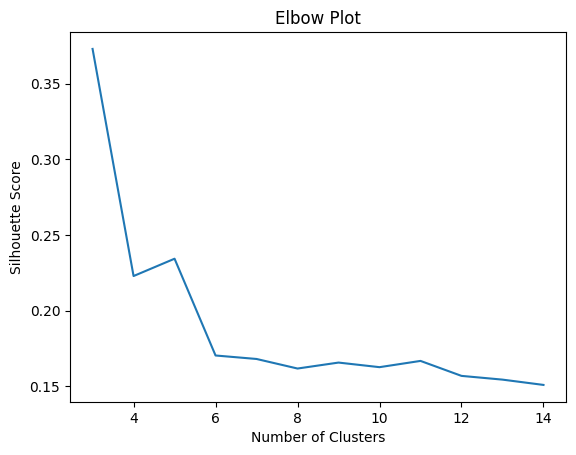

In [24]:
demo_data = data[['race_percent_white', 'race_percent_black',
       'race_percent_native', 'race_percent_asian',
       'race_percent_pacific_islander', 'race_percent_hispanic',
       'race_percent_other', 'income_percent_below_15K',
       'income_percent_15K_35K', 'income_percent_35K_65K',
       'income_percent_above_65K', 'male_percent', 'female_percent',
       'disability_percent', 'male_disability_percent',
       'female_disability_percent']]


# Elbow Plot
range_n_clusters = range(3, 15)
scores = []
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(demo_data)
    silhouette_avg = silhouette_score(demo_data, cluster_labels)
    scores.append(silhouette_avg)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    
plt.plot(range_n_clusters, scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Elbow Plot')
plt.show()


In [25]:
best_cluster = 6

clusterer = KMeans(n_clusters=best_cluster, random_state=10)
cluster_labels = clusterer.fit_predict(demo_data)

data['cluster'] = cluster_labels

In [28]:
for i in range(best_cluster):
    print('Cluster', i, 'has:', len(data[data['cluster'] == i]), 'precincts')


Cluster 0 has: 325 precincts
Cluster 1 has: 90 precincts
Cluster 2 has: 145 precincts
Cluster 3 has: 231 precincts
Cluster 4 has: 167 precincts
Cluster 5 has: 174 precincts


Notes:
- Cluster 0 is extremely white, with most income above 35K, and 12% disability rates. (Bethel Park, Ross, Shaler, Pittsburgh Ward 10)
- Cluster 1 is majority black, with most income below 35K, and 25% disability rates. (Homestead, McKeesport, Pittsburgh Ward 5)
- Cluster 2 is majority white, but income is evenly spread out, with 13% disability rates. (Coraopolis, Monroeville, Pitt Wards 4, 7, and 23)
- Cluster 3 is extremely white, with most of the population below 65K, and 18% disability rates. (Brentwood, West Mifflin)
- Cluster 4 is half white and half black, with most income below 65K, and 16% disability rates. (Clairton, Duquesne)
- Cluster 5 is extremely white, with almost half of income above 65K, and 9% disability rates. (Bethel Park, Fox Chapel)


In [55]:
precinct_data = gpd.read_file('relevant_precincts.geojson').to_crs('EPSG:3395')

In [57]:
precinct_data = precinct_data.merge(data, left_on='district', right_on='district')

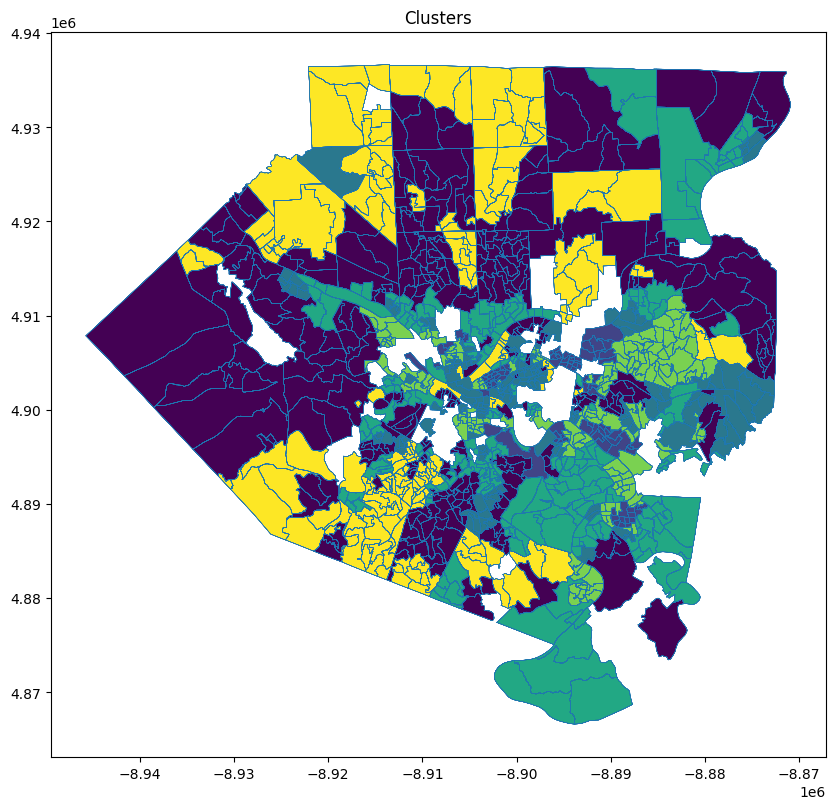

In [67]:
import seaborn as sns
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
precinct_data.plot(column='cluster', ax=ax, legend=False)
precinct_data.boundary.plot(ax=ax, linewidth=0.2)
plt.title('Clusters')
plt.show()

In [87]:
hours = ['7 AM', '8 AM', '9 AM', '10 AM', '11 AM', '12 PM', '1 PM',
         '2 PM', '3 PM', '4 PM', '5 PM', '6 PM', '7 PM']

fixed_weights = [0.30] + [0.20 /6]*6 + [0.50 /6]*6 

def randomize_ballots(row, weight):
    return int(np.random.randint((row['ballots_cast'] * 0.8), (row['ballots_cast'] * 1.2)) * weight) 

for i, hour in enumerate(hours):
    data[hour] = data.apply(lambda x: randomize_ballots(x, fixed_weights[i]), axis=1)


In [90]:
data

,total,race_percent_white,race_percent_black,race_percent_native,race_percent_asian,race_percent_pacific_islander,race_percent_hispanic,race_percent_other,income_percent_below_15K,income_percent_15K_35K,income_percent_35K_65K,income_percent_above_65K,male_percent,female_percent,disability_percent,male_disability_percent,female_disability_percent,district,year,is_midterm,lagged_turnout,lagged_percentage_turnout,ballots_cast,check_in_stations,voting_booths,cluster,7 AM,8 AM,9 AM,10 AM,11 AM,12 PM,1 PM,2 PM,3 PM,4 PM,5 PM,6 PM,7 PM
0,3587.021486,0.924896,0.003024,5.720420e-03,0.010605,0.000000e+00,0.028436,0.004876,0.146698,0.227556,0.174298,0.376845,0.472122,0.527878,0.209212,0.089035,0.120178,ALEPPO,2026,1,1128,82.76,1127,1,3,0,297,35,39,39,33,31,38,85,91,95,77,104,80
1,2819.197463,0.741135,0.065131,1.319492e-07,0.182826,0.000000e+00,0.004830,0.002541,0.056678,0.066834,0.254476,0.511867,0.417552,0.580313,0.100020,0.015977,0.084043,ASPINWALL DIST 1,2026,1,730,85.38,629,1,3,5,193,22,23,21,19,22,20,62,57,60,51,52,44
2,2830.095799,0.743008,0.065388,0.000000e+00,0.182487,0.000000e+00,0.004958,0.002505,0.057540,0.067789,0.254728,0.512205,0.419150,0.580850,0.100290,0.016164,0.084126,ASPINWALL DIST 2,2026,1,472,81.10,427,1,3,5,141,14,12,16,14,14,12,28,39,34,40,33,38
3,2831.447923,0.743035,0.065403,0.000000e+00,0.182351,0.000000e+00,0.004980,0.002494,0.057671,0.067945,0.254672,0.512033,0.419255,0.580708,0.100306,0.016192,0.084114,ASPINWALL DIST 3,2026,1,698,84.40,618,1,3,5,157,20,20,20,20,22,21,55,53,45,53,50,46
4,2203.983574,0.713338,0.229701,2.699011e-03,0.003748,0.000000e+00,0.026200,0.009296,0.178168,0.297448,0.284030,0.187192,0.605259,0.394741,0.234994,0.151556,0.083438,AVALON WARD 1,2026,1,849,76.14,707,1,3,2,196,22,20,19,19,22,21,64,48,54,61,59,57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1127,1480.000000,0.222341,0.710557,0.000000e+00,0.000000,1.000000e-03,0.092573,0.020546,0.423703,0.165827,0.169286,0.169470,0.431081,0.568919,0.286486,0.065541,0.220946,PITTSBURGH WARD 12 DIST 2,2026,1,153,50.50,99,1,3,1,33,2,2,3,2,3,3,8,7,9,9,6,9
1128,1809.711974,0.093957,0.840640,0.000000e+00,0.000000,8.728051e-07,0.000000,0.099325,0.031905,0.607462,0.054432,0.299521,0.472320,0.527680,0.177457,0.000000,0.185119,PITTSBURGH WARD 12 DIST 9,2026,1,138,48.25,97,1,3,1,27,3,3,2,2,3,2,6,7,9,6,7,7
1129,3307.068654,0.374426,0.344919,4.739217e-03,0.021817,0.000000e+00,0.000000,0.000012,0.146051,0.083124,0.146735,0.552089,0.558772,0.441228,0.176877,0.132123,0.044753,PITTSBURGH WARD 21 DIST 3,2026,1,402,66.12,336,1,3,2,93,9,12,10,11,9,12,30,25,31,27,23,28
1130,3469.000000,0.685764,0.240840,2.710061e-02,0.000000,0.000000e+00,0.000799,0.029101,0.139538,0.159396,0.204255,0.364556,0.464975,0.535025,0.127703,0.084462,0.043240,PITTSBURGH WARD 22 DIST 2,2026,1,487,72.58,428,1,3,2,130,16,16,13,15,16,13,38,29,31,29,32,40


In [89]:
data.to_csv('2026_full_data.csv', index=False)